# Stock Price Prediction
Let's say we want to make money by buying stocks. Since we want to make money, we only want to buy stock on days when the price will go up (we're against shorting the stock). We'll create a machine learning algorithm to predict if the stock price will increase tomorrow. If the algorithm says that the price will increase, we'll buy stock. If the algorithm says that the price will go down, we won't do anything.

We want to maximize our true positives - days when the algorithm predicts that the price will go up, and it actually goes go up. Therefore, we'll be using precision as our error metric for our algorithm, which is true positives / (false positives + true positives). This will ensure that we minimize how much money we lose with false positives (days when we buy the stock, but the price actually goes down).

This means that we will have to accept a lot of false negatives - days when we predict that the price will go down, but it actually goes up. This is okay, since we'd rather minimize our potential losses than maximize our potential gains.

## Method

Before we get to the machine learning, we need to do a lot of work to acquire and clean up the data. Here are the steps we'll follow:

- Download historical stock prices from Yahoo finance
- Explore the data
- Setup the dataset to predict future prices using historical prices
- Test a machine learning model
- Setup a backtesting engine
- Improve the accuracy of the model

At the end, we'll document some potential future directions we can go in to improve the technique.

Downloading the data
First, we'll download the data from Yahoo Finance. We'll save the data after we download it, so we don't have to re-download it every time (this could cause our IP to get blocked).

We'll use data for a single stock (Microsoft) from when it started trading to the present.



In [225]:
import yfinance as yf
import os
import json
import pandas as pd

msft_hist = pd.read_csv('qqq_data.csv', index_col="Date", parse_dates=True)
msft_hist = msft_hist.asfreq('D')
msft_hist = msft_hist.fillna(method='ffill')
print (msft_hist)

                 Open     High       Low      Close         EMA  \
Date                                                              
2013-09-13   78.11000   78.145   77.6400   78.06000   76.043566   
2013-09-14   78.11000   78.145   77.6400   78.06000   76.043566   
2013-09-15   78.11000   78.145   77.6400   78.06000   76.043566   
2013-09-16   78.69000   78.720   77.6700   77.85001   76.148514   
2013-09-17   77.99001   78.470   77.9800   78.37000   76.249806   
...               ...      ...       ...        ...         ...   
2022-06-17  272.18000  277.190  270.5119  274.69000  303.730053   
2022-06-18  272.18000  277.190  270.5119  274.69000  303.730053   
2022-06-19  272.18000  277.190  270.5119  274.69000  303.730053   
2022-06-20  272.18000  277.190  270.5119  274.69000  303.730053   
2022-06-21  278.75000  283.450  278.6400  281.08000  302.623465   

            Smoothing Line      Volume    Volume MA        RSI        ROC  \
Date                                               

As we can see, we have one row of data for each day that Microsoft stock was traded. Here are the columns:

- Open - the price the stock opened at.
- High - the highest price during the day
- Low - the lowest price during the day
- Close - the closing price on the trading day
- Volume - how many shares were traded

Stock doesn't trade every day (there is no trading on weekends and holidays), so some dates are missing.

In [226]:
# Display microsoft stock price history so we can look at the structure of the data
msft_hist.tail(5)

,Open,High,Low,Close,EMA,Smoothing Line,Volume,Volume MA,RSI,ROC,Williams,Histogram,MACD,Signal,CCI,Smoothing Line.1,DIX 1,DIX 2,DIX 3
Date,,,,,,,,,,,,,,,,,,,
2022-06-17,272.18,277.19,270.5119,274.69,303.730053,306.806450,82703402.0,67785401.40,36.475042,-10.588503,-88.052120,-2.311268,-9.006170,-6.694902,-115.397245,-134.733780,-23.181525,-12.201419,-6.572586
2022-06-18,272.18,277.19,270.5119,274.69,303.730053,306.806450,82703402.0,67785401.40,36.475042,-10.588503,-88.052120,-2.311268,-9.006170,-6.694902,-115.397245,-134.733780,-23.181525,-12.201419,-6.572586
2022-06-19,272.18,277.19,270.5119,274.69,303.730053,306.806450,82703402.0,67785401.40,36.475042,-10.588503,-88.052120,-2.311268,-9.006170,-6.694902,-115.397245,-134.733780,-23.181525,-12.201419,-6.572586
2022-06-20,272.18,277.19,270.5119,274.69,303.730053,306.806450,82703402.0,67785401.40,36.475042,-10.588503,-88.052120,-2.311268,-9.006170,-6.694902,-115.397245,-134.733780,-23.181525,-12.201419,-6.572586
2022-06-21,278.75,283.45,278.6400,281.08,302.623465,305.355255,51633741.0,65778879.75,41.089689,-9.290993,-73.939929,-1.705609,-8.826913,-7.121304,-72.560159,-115.407089,-20.178350,-9.272204,-3.754574


Next, we'll plot the data so we can see how the stock price has changed over time. This gives us another overview of the structure of the data.

<AxesSubplot:xlabel='Date'>

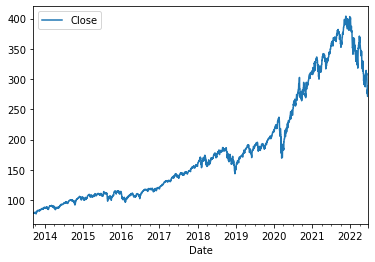

In [227]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [231]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [281]:
msft_hist = msft_hist[['Close']]
msft_hist.head(5)

,Close
Date,
2013-09-13,78.06000
2013-09-14,78.06000
2013-09-15,78.06000
2013-09-16,77.85001
2013-09-17,78.37000


In [282]:
data = msft_hist

ses = SimpleExpSmoothing(data)

alpha = 0.2
model = ses.fit(smoothing_level = alpha, optimized = False)

/Users/mylesosborn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


In [283]:
forcast = model.forecast(3)
forcast

/Users/mylesosborn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


2022-06-22    279.307461
2022-06-23    279.307461
2022-06-24    279.307461
Freq: D, dtype: float64

## Preparing the data

Ok, hopefully you've stopped kicking yourself for not buying Microsoft stock at any point in the past 30 years now.

Now, let's prepare the data so we can make predictions. We'll be predicting if the price will go up or down tomorrow based on data from today.

First, we'll identify a target that we're trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be 1 and if it went down, the target will be 0.

Next, we'll shift the data from previous days "forward" one day, so we can use it to predict the target price. This ensures that we don't accidentally use data from the same day to make predictions! (a very common mistake)

Then, we'll combine both so we have our training data.

In [161]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [162]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [163]:
msft_prev.head(2000)

,Open,High,Low,Close,Volume,EMA,Smoothing Line
Date,,,,,,,
9/13/13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9/16/13,78.11000,78.145,77.640,78.06000,16932448.0,76.043566,75.837416
9/17/13,78.69000,78.720,77.670,77.85001,25909888.0,76.148514,75.943957
9/18/13,77.99001,78.470,77.980,78.37000,27182208.0,76.249806,76.046325
9/19/13,78.49001,79.470,78.330,79.31000,31714656.0,76.379084,76.153944
...,...,...,...,...,...,...,...
8/17/21,367.67000,369.020,363.700,368.98000,35044107.0,359.534175,358.736998
8/18/21,366.15000,367.150,363.230,365.73000,44793902.0,359.810069,359.117266
8/19/21,365.18000,366.620,361.865,362.21000,38541940.0,360.026285,359.454570


In [164]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low", "EMA", "Smoothing Line"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [167]:
data.head(3000)

,Actual_Close,Target,Close,Volume,Open,High,Low,EMA,Smoothing Line
Date,,,,,,,,,
9/16/13,77.85001,0.0,78.06000,16932448.0,78.11000,78.145,77.6400,76.043566,75.837416
9/17/13,78.37000,1.0,77.85001,25909888.0,78.69000,78.720,77.6700,76.148514,75.943957
9/18/13,79.31000,1.0,78.37000,27182208.0,77.99001,78.470,77.9800,76.249806,76.046325
9/19/13,79.50000,1.0,79.31000,31714656.0,78.49001,79.470,78.3300,76.379084,76.153944
9/20/13,78.98500,0.0,79.50000,26435616.0,79.53999,79.685,79.3600,76.532421,76.270678
...,...,...,...,...,...,...,...,...,...
6/14/22,275.91000,1.0,275.41000,94442009.0,279.75000,282.340,274.5300,309.879443,311.990305
6/15/22,282.80000,1.0,275.91000,64697521.0,277.66000,278.660,273.3375,308.226726,311.009761
6/16/22,271.39000,0.0,282.80000,86051428.0,279.41500,286.830,276.6100,306.933715,309.808512


## Creating a machine learning model
Next, we'll create a machine learning model to see how accurately we can predict the stock price.

Because we're dealing with time series data, we can't just use cross-validation to create predictions for the whole dataset. This will cause leakage where data from the future will be used to predict past prices. This doesn't match with the real world, and will make us think that our algorithm is much better than it actually is.

Instead, we'll split the data sequentially. We'll start off by predicting just the last 100 rows using the other rows.

We'll use a random forest classifier to generate our predictions. This is a good "default" model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.

In [186]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=1000, min_samples_split=300, random_state=1)

# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=300, n_estimators=1000, random_state=1)

Next, we'll need to check how accurate the model was. Earlier, we mentioned using precision to measure error. We can do this by using the precision_score function from scikit-learn.

In [187]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.46464646464646464

In [177]:
preds

Date
1/27/22    1.0
1/28/22    1.0
1/31/22    1.0
2/1/22     1.0
2/2/22     1.0
          ... 
6/14/22    1.0
6/15/22    1.0
6/16/22    1.0
6/17/22    1.0
6/21/22    1.0
Length: 100, dtype: float64

So our model is directionally accurate XX% of the time. This is only a little bit better than a coin flip! We can take a deeper look at the individual predictions and the actuals, and see where we're off.

<AxesSubplot:xlabel='Date'>

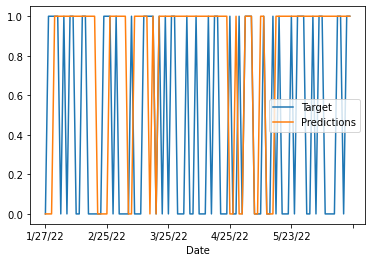

In [136]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

## Backtesting
Our model isn't great, but luckily we can still improve it. Before we do that, let's figure out how to make predictions across the entire dataset, not just the last 100 rows. This will give us a more robust error estimate. The last 100 days may have has atypical market conditions or other issues that make error metrics on those days unrealistic for future predictions (which are what we really care about).

To do this, we'll need to backtest. Backtesting ensures that we only use data from before the day that we're predicting. If we use data from after the day we're predicting, the algorithm is unrealistic (in the real world, you won't be able to use future data to predict that past!).

Our backtesting method will loop over the dataset, and train a model every 750 rows. We'll make it a function so we can avoid rewriting the code if we want to backtest again.

In the backtesting function, we will:

- Split the training and test data
- Train a model
- Make predictions on the test data using predict_proba - this is because we want to really optimize for true positives. By default, the threshold for splitting 0/1 is .5, but we can set it to different values to tweak the precision. If we set it too high, we'll make fewer trades, but will have a lower potential for losses.

In [138]:
start = 
step = 750
i = 1000

train = data.ilock[0:i].copy()
test = data.ilock[i:(i+step)].copy()

model.fit(train[predictors], train["Target"])

preds = model.predict_proba(test[predictors]
preds

array([[0.69665254, 0.30334746],
       [0.68128313, 0.31871687],
       [0.69715673, 0.30284327],
       ...,
       [0.6989903 , 0.3010097 ],
       [0.699973  , 0.300027  ],
       [0.6989903 , 0.3010097 ]])

In [100]:
list1 = preds.tolist()

In [102]:
list1

[0.36780384673091615,
 0.3900217400297855,
 0.3657820786038,
 0.36780384673091615,
 0.3701316779147066,
 0.3660587575177609,
 0.3642935738652952,
 0.3660587575177609,
 0.36372151080763393,
 0.3641231419422429,
 0.36672627223334164,
 0.36788620426409335,
 0.36498598957211276,
 0.369640980240288,
 0.4718474000655454,
 0.5948241648691192,
 0.6436050278700173,
 0.45903266404873944,
 0.471942600694971,
 0.36400157298091157,
 0.3660587575177609,
 0.3694598632289504,
 0.3660587575177609,
 0.3642473360503524,
 0.36780384673091615,
 0.3647389593516481,
 0.369105395143844,
 0.34562306887409117,
 0.3694918066378718,
 0.36798243736208736,
 0.36780384673091615,
 0.3662729812158598,
 0.3684298827461607,
 0.3660587575177609,
 0.3642935738652952,
 0.3645554786272,
 0.3694598632289504,
 0.36368757687593856,
 0.3660587575177609,
 0.36399680717731225,
 0.3642473360503524,
 0.3660587575177609,
 0.3645554786272,
 0.36451759983932125,
 0.36643042249580887,
 0.36556805984334234,
 0.36780384673091615,
 0.3683

In [103]:
def backtest(data, model, predictors, start=1000, step=100):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        # Fit the random forest model
        model.fit(train[predictors], train["Target"])
        
        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        
        
        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
        
        predictions.append(combined)
    
    return pd.concat(predictions)

In [105]:
predictions

,Target,Predictions
Date,,
9/5/17,0.0,0.0
9/6/17,1.0,0.0
9/7/17,1.0,0.0
9/8/17,0.0,0.0
9/11/17,1.0,0.0
...,...,...
6/14/22,1.0,0.0
6/15/22,1.0,0.0
6/16/22,0.0,0.0


In [72]:
predictions = backtest(data, model, predictors)

In [60]:
predictions["Predictions"].value_counts()

0.0    865
1.0    342
Name: Predictions, dtype: int64

In [61]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5614035087719298

In [62]:
predictions

,Target,Predictions
Date,,
9/5/17,0.0,0.0
9/6/17,1.0,0.0
9/7/17,1.0,0.0
9/8/17,0.0,0.0
9/11/17,1.0,0.0
...,...,...
6/14/22,1.0,0.0
6/15/22,1.0,0.0
6/16/22,0.0,0.0


## Improving accuracy
The model isn't very accurate, but at least now we can make predictions across the entire history of the stock. For this model to be useful, we have to get it to predict more accurately.

Let's add some more predictors to see if we can improve accuracy.

We'll add in some rolling means, so the model can evaluate the current price against recent prices. We'll also look at the ratios between different indicators.

In [63]:
weekly_mean = data.rolling(7).mean()
quarterly_mean = data.rolling(90).mean()
annual_mean = data.rolling(365).mean()
weekly_trend = data.shift(1).rolling(7).mean()["Target"]

In [64]:
data["weekly_mean"] = weekly_mean["Close"] / data["Close"]
data["quarterly_mean"] = quarterly_mean["Close"] / data["Close"]
data["annual_mean"] = annual_mean["Close"] / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]
data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [65]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [66]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5260115606936416

In [67]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    669
1.0    173
Name: Predictions, dtype: int64

<AxesSubplot:xlabel='Date'>

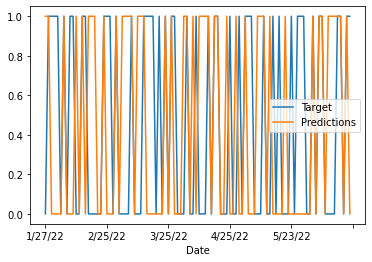

In [68]:
predictions.iloc[-100:].plot()

In [69]:
predictions

,Target,Predictions
Date,,
2/19/19,1.0,0.0
2/20/19,0.0,0.0
2/21/19,0.0,0.0
2/22/19,1.0,0.0
2/25/19,1.0,0.0
...,...,...
6/14/22,1.0,1.0
6/15/22,1.0,1.0
6/16/22,0.0,0.0


## Next steps
We've come far in this project! We've downloaded and cleaned data, and setup a backtesting engine. We now have an algorithm that we can add more predictors to and continue to improve the accuracy of.

There are a lot of next steps we could take to improve our predictions:

## Improve the technique
- Calculate how much money you'd make if you traded with this algorithm

## Improve the algorithm
- Run with a reduced step size! This will take longer, but increase accuracy
- Try discarding older data (only keeping data in a certain window)
- Try a different machine learning algorithm
- Tweak random forest parameters, or the prediction threshold

## Add in more predictors
- Account for activity post-close and pre-open.
  - Early trading
  - Trading on other exchanges that open before the NYSE (to see what the global sentiment is)
- Economic indicators
  - Interest rates
  - Other important economic news
- Key dates
  - Dividends
  - External factors like elections
- Company milestones
  - Earnings calls
  - Analyst ratings
  - Major announcements
- Prices of related stocks
  - Other companies in the same sector
  - Key partners, customers, etc.